In [218]:
import numpy as np
from sklearn.datasets import make_regression,make_classification
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd

### Linear regression

In [364]:
#implementing linear regression
#numeric algorithm
class LinearRegression():
    def __init__(self,alpha = 0.01,iters = 100):
        self.alpha = alpha
        self.iters = iters
        self.errors = []
        self.weights = None
        self.N = None

    def J(self,y_pred,y_true):
        return 1/(2*self.N)*((y_pred-y_true)**2).sum()
        
    def grad_J(self,X,y_pred,y_true):
        return 1/self.N*X.T@(y_pred-y_true)

    def fit(self,X,y):
        ones = np.ones((X.shape[0],1))
        X = np.hstack((ones,X))
        self.N = X.shape[0]
        #initialize weights 
        self.weights = np.random.default_rng().standard_normal((X.shape[1],1))
        #updating weights for a given number of iterations
        for _ in range(self.iters):
            y_pred = X@self.weights
            error = self.J(y_pred,y)
            self.errors.append(error)
            gradient = self.grad_J(X,y_pred,y)
            self.weights -= gradient*self.alpha
        if self.errors[-1] > self.errors[0]:
            raise Exception('The algorithm is not diverging')

In [378]:
X,y = make_regression(
    n_samples = 100,
    n_features = 2,
    noise = 10,
    random_state = 42
)

In [379]:
X.shape

(100, 2)

In [380]:
y = y.reshape((100,1))

In [381]:
y.shape

(100, 1)

In [382]:
#My model
the_reg = LinearRegression(iters = 2000)
the_reg.fit(X,y)
the_reg.weights

array([[ 0.21633426],
       [86.0025187 ],
       [74.11676148]])

In [383]:
#sklearn model
lin_model = sklearn.linear_model.LinearRegression().fit(X,y)
lin_model

LinearRegression()

In [384]:
lin_model.intercept_

array([0.21635808])

In [385]:
lin_model.coef_

array([[86.00258028, 74.11675411]])

In [388]:
#the results are the same 
#when to stop iterations, so that is is not a hyperparameter?

### classification 

In [37]:
classif_data = make_classification(n_samples = 500,n_features = 2,
                                   n_informative=2,n_redundant = 0,
                                   class_sep = 3,n_clusters_per_class = 1)

In [38]:
type(classif_data)

tuple

In [39]:
X,y = classif_data

In [40]:
print(X.shape,y.shape)

(500, 2) (500,)


In [41]:
def plot_dataset():
    some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
    some_ax = some_figure.add_subplot()

    some_ax.grid(linestyle = '--',c = 'purple',alpha = 0.3)
    some_ax.scatter(X.T[0,:],[X.T[1,:]],c = y,alpha = 0.3)
    some_ax.set_xlabel('x1')
    some_ax.set_ylabel('x2')
    return some_ax

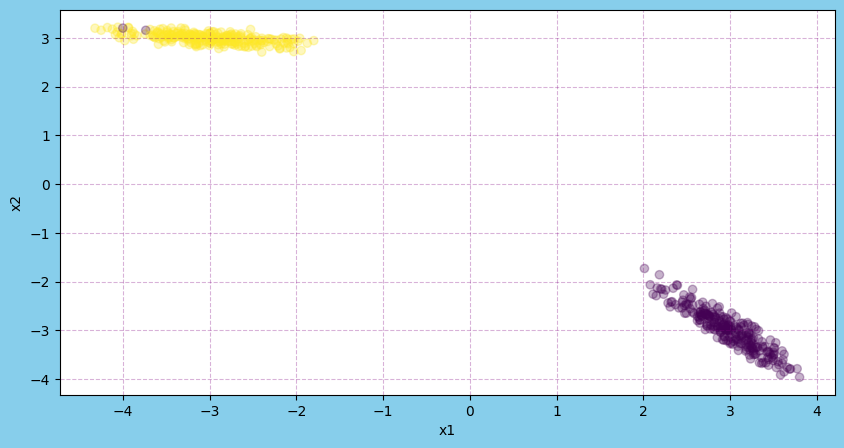

In [42]:
ax1 = plot_dataset()

In [43]:
class PerceptLoss(object):
    def __init__(self,svm = False):
        self.svm = svm
    
    def __call__(self,y_true,y_pred):
        #all vectors shoud be 2-dimensional

        #if it is svm 
        if self.svm == True:
            res = 1 - y_true*y_pred
            res[res >= 0] = 0
            return float(res.sum()) 
        
        res = -y_true*y_pred
        res[res<0] = 0
        return float(res.sum())

class PerceptGrad(object):
    def __init__(self,svm = False):
        self.svm = svm

    def __call__(self,y_true,y_pred,X):
        #y_true is 2-dimensional
        #as all of the other parameters
        if self.svm == True:
            main_mask = (1 - y_pred > 0).reshape(-1)
            x_pos = X[main_mask]
            y_true = y_true[main_mask]
            gradient = (-y_true*x_pos).sum(axis = 0)
            return gradient.reshape(gradient.shape[0],1)

        main_mask = (y_pred <= 0).reshape(-1) 
        x_neg = X[main_mask]
        y_true = y_true[main_mask]
        gradient = (-y_true*x_neg).sum(axis = 0) 
        return gradient.reshape(gradient.shape[0],1)


class Rosenblatt(object):
    def __init__(self,alpha = 0.05,n_iters = 100,svm = False):
        self.alpha = alpha
        self.n_iters = n_iters
        self.svm = svm
        self.weights = None
        self.errors = []
    
    def fit(self,X,y,regularization = False,lam = 0.5):
        self.weights = np.random.default_rng().standard_normal((X.shape[1],1))
        y = y.reshape(y.shape[0],1)

        if self.svm == False:
            loss = PerceptLoss()
            grad = PerceptGrad()
        else:
            loss = PerceptLoss(svm = True)
            grad = PerceptGrad(svm = True)


        for epoch in range(self.n_iters):
            y_pred = X@self.weights
            if regularization == False:
                the_loss = loss(y_true=y,y_pred = y_pred)
            else:
                the_loss = loss(y_true=y,y_pred = y_pred) + lam*(self.weights**2).sum()
            self.errors.append(round(the_loss,5))
            the_grad = grad(y_true = y,y_pred = y_pred,X = X)
            if regularization == False:
                self.weights -= self.alpha*the_grad
            else:
                self.weights -= self.alpha*(the_grad + 2*lam*self.weights)

In [44]:
rosenb = Rosenblatt(alpha=0.01,n_iters=2000)
print(rosenb.weights)

None


In [46]:
rosenb.fit(X,y)
print(rosenb.weights)

[[-6.31515372]
 [ 7.32665988]]


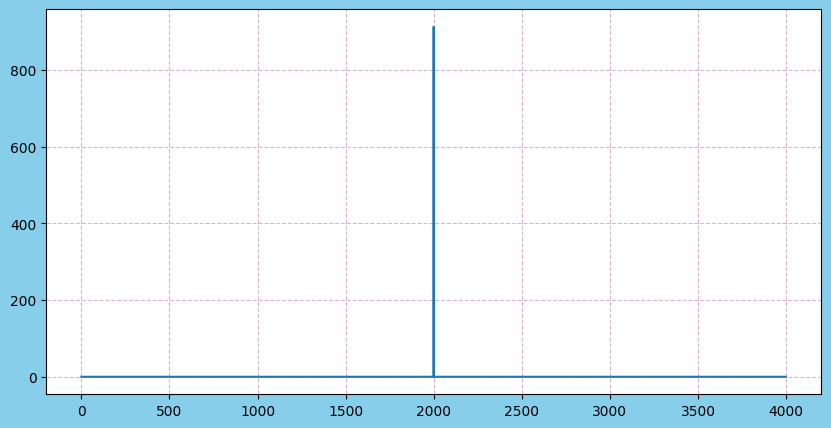

In [47]:
error_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
error_ax = error_figure.add_subplot()
error_ax.grid(linestyle = '--',c = 'purple',alpha = 0.3)

error_ax.plot([k for k in range(len(rosenb.errors))],rosenb.errors)

In [48]:
rosenb_lines = []
for _ in range(6):
    rosenb.fit(X,y)
    rosenb_lines.append(rosenb.weights)

In [49]:
rosenb_lines

[array([[-7.12021789],
        [ 5.64641038]]),
 array([[-0.96733111],
        [ 1.92217701]]),
 array([[-1.35489353],
        [ 0.57692272]]),
 array([[-7.57509772],
        [ 6.70988159]]),
 array([[-1.28299135],
        [ 1.1865155 ]]),
 array([[-7.16691621],
        [ 6.24193988]])]

In [50]:
#it basically shows that the rosenblatt solution is not unique
#but it fits quite well

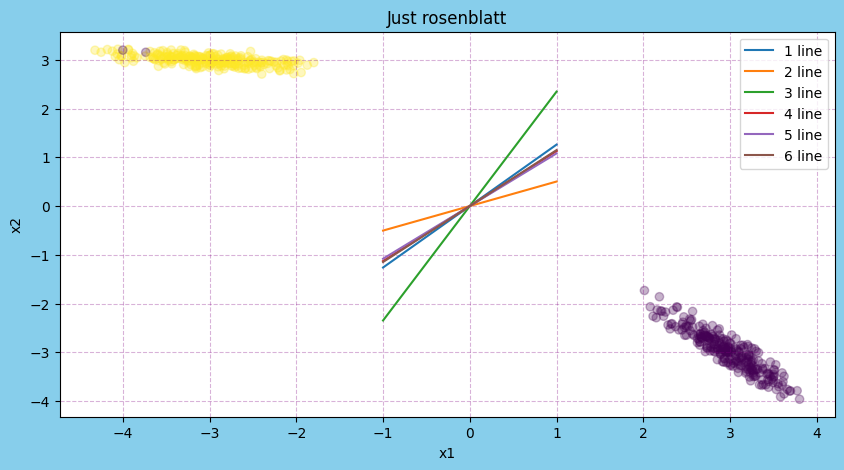

In [51]:
main_ax = plot_dataset()
main_ax.set_title('Just rosenblatt')
count = 0
for one_hyperplane in rosenb_lines:
    count += 1
    main_ax.plot(np.linspace(-1,1,100),one_hyperplane[0,0]/one_hyperplane[1,0]*(-1)*np.linspace(-1,1,100),label = f'{count} line')
main_ax.legend()

In [59]:
rosenb = Rosenblatt(alpha=0.025,n_iters=800,svm = True)
print(rosenb.weights)

None


In [60]:
rosenb.fit(X,y)
print(rosenb.weights)

[[-0.58791249]
 [ 1.10119532]]


In [61]:
rosenb_lines = []
for _ in range(6):
    rosenb.fit(X,y)
    rosenb_lines.append(rosenb.weights)

In [62]:
rosenb_lines

[array([[-16.16924875],
        [ 17.00613633]]),
 array([[-1.62146977],
        [-0.3247615 ]]),
 array([[-17.98718065],
        [ 18.93146662]]),
 array([[-16.95909605],
        [ 19.11284769]]),
 array([[-18.65266519],
        [ 18.80687672]]),
 array([[-0.44455949],
        [ 0.76906065]])]

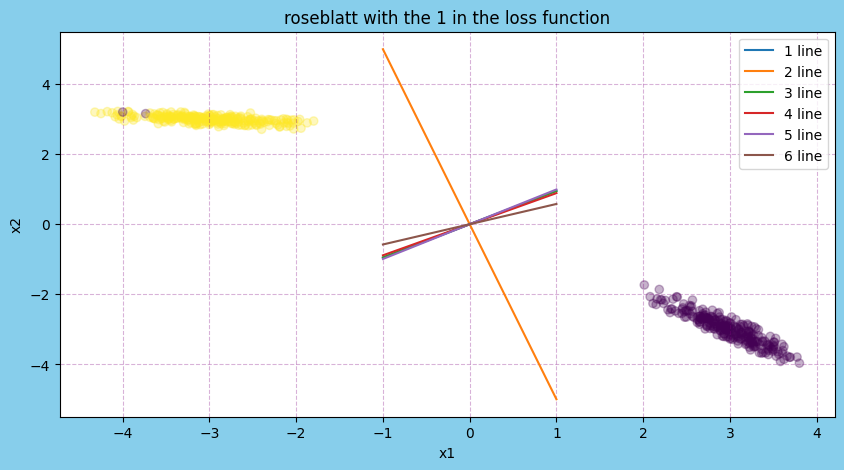

In [63]:
#the loss function with the 1 seems to be unique
#but it is not that good actually

main_ax = plot_dataset()
main_ax.set_title('roseblatt with the 1 in the loss function')
count = 0
for one_hyperplane in rosenb_lines:
    count += 1
    main_ax.plot(np.linspace(-1,1,100),one_hyperplane[0,0]/one_hyperplane[1,0]*(-1)*np.linspace(-1,1,100),label = f'{count} line')
main_ax.legend()

In [64]:
rosenb = Rosenblatt(alpha=0.01,n_iters=2000,svm = False)
print(rosenb.weights)

None


In [65]:
rosenb.fit(X,y,regularization = True,lam = 1.8)
print(rosenb.weights)

[[-9.20305018e-32]
 [ 9.71964282e-32]]


In [66]:
rosenb_lines = []
for _ in range(6):
    rosenb.fit(X,y,regularization = True,lam = 1.8)
    rosenb_lines.append(rosenb.weights)

In [67]:
rosenb_lines

[array([[-8.54510714e-32],
        [ 1.15583431e-31]]),
 array([[-1.02536238e-31],
        [ 1.00678439e-31]]),
 array([[3.40731278e-34],
        [4.62378585e-33]]),
 array([[-1.00730888e-32],
        [ 2.19993114e-32]]),
 array([[-2.31380899e-33],
        [ 1.16095561e-33]]),
 array([[-9.79199510e-32],
        [ 1.04830022e-31]])]

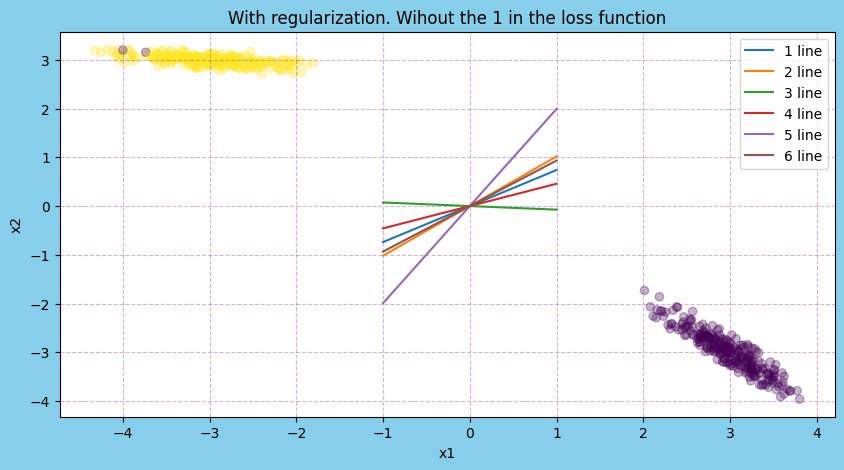

In [68]:
#adding the regularization without the 1 present in the loss function still does not makes the solution unique 
#this is what we can see from the expirements
#but it is quite close, though

main_ax = plot_dataset()
main_ax.set_title('With regularization. Wihout the 1 in the loss function')
count = 0
for one_hyperplane in rosenb_lines:
    count += 1
    main_ax.plot(np.linspace(-1,1,100),one_hyperplane[0,0]/one_hyperplane[1,0]*(-1)*np.linspace(-1,1,100),label = f'{count} line')
main_ax.legend()

In [69]:
rosenb = Rosenblatt(alpha=0.01,n_iters=2000,svm = True)
print(rosenb.weights)

None


In [71]:
rosenb.fit(X,y,regularization = True,lam = 1.8)
print(rosenb.weights)

[[-0.17577343]
 [ 0.25372963]]


In [72]:
rosenb_lines = []
for _ in range(6):
    rosenb.fit(X,y,regularization = True,lam = 1.8)
    rosenb_lines.append(rosenb.weights)

In [73]:
rosenb_lines

[array([[-0.18127264],
        [ 0.26322559]]),
 array([[-0.17577343],
        [ 0.25372963]]),
 array([[-0.22587599],
        [ 0.32799401]]),
 array([[-0.21923546],
        [ 0.31860938]]),
 array([[-0.17594341],
        [ 0.25569413]]),
 array([[-0.23431119],
        [ 0.34024274]])]

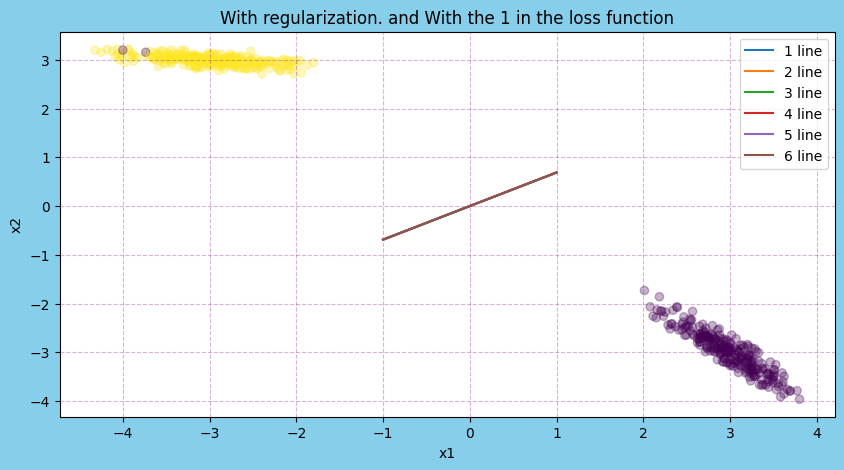

In [74]:
#in the case that we add 1 to the loss function
#and we use regularization, we get more or less a unique solution
#it seems that the more we restrict the more the solution becomes unique
#need more math to understand it better

main_ax = plot_dataset()
main_ax.set_title('With regularization. and With the 1 in the loss function')
count = 0
for one_hyperplane in rosenb_lines:
    count += 1
    main_ax.plot(np.linspace(-1,1,100),one_hyperplane[0,0]/one_hyperplane[1,0]*(-1)*np.linspace(-1,1,100),label = f'{count} line')
main_ax.legend()

### Logistic regression 

In [203]:
class Sigmoid(object):
    def __call__(self,X):
        return 1/(1+np.exp(-X))

class l_loss(object):
    def __init__(self,eps = 10**-5):
        self.eps = eps

    def __call__(self,y_pred,y_true):
        #y_pred is a column_vector
        #y_true is a row-vector
        #therefore need to reshape it
        y_true = y_true.reshape(y_true.shape[0],1)
        to_sum_vector = -(y_true*np.log(y_pred+self.eps) + (1-y_true)*np.log(1-y_pred+self.eps))
        return float(to_sum_vector.sum())

class grad_l(object):
    def __call__(self,y_true,X,y_pred):
        #y_true is a row-vector
        #y_pred is a colum vecotr
        #X has 2 columns
        y_true = y_true.reshape(y_true.shape[0],1)
        to_sum = -(X*(y_true-y_pred))
        row_sum = to_sum.sum(axis = 0)
        return row_sum.reshape(row_sum.shape[0],1)

class LogisicRegression(object):
    def __init__(self,n_iters = 100,alpha = 0.05):
        #weights are initialized for 2 feature problem
        self.weights = np.random.default_rng().standard_normal((2,1))
        self.errors = []
        self.n_iters = n_iters
        self.alpha = alpha
        self.loss = l_loss()
        self.grad = grad_l()
        self.sigmoid = Sigmoid()
    
    def predict(self,X):
        #X should have 2 columns
        return self.sigmoid(X@self.weights)
    
    def fit(self,X,y):
        for epoch in range(self.n_iters):
            y_pred = self.predict(X)
            the_loss = self.loss(y_true = y,y_pred = y_pred)
            self.errors.append(round(the_loss,6))
            the_grad = self.grad(y_true = y,X = X,y_pred = y_pred)
            self.weights -= self.alpha*the_grad


In [205]:
logreg = LogisicRegression(n_iters=2000,alpha=10**-4)

In [206]:
logreg.fit(X,y)

In [219]:
def to_labels(prediction):
    prediction[prediction >= 0.5] = 1
    prediction[prediction < 0.5] = 0
    return (prediction.astype(np.int64)).reshape(-1)

In [223]:
y_pred = to_labels(logreg.predict(X))
print(y_pred.shape,y.shape)

(500,) (500,)


In [224]:
accuracy_score(y_pred = y_pred,y_true = y)

0.996